In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

In [2]:
train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 99107537.87it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 13818810.61it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 62738278.54it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2139547.26it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
x_train = train_dataset.data
y_train = train_dataset.targets

In [5]:
test_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=transforms.ToTensor(), download=True)

In [6]:
x_test = test_dataset.data
y_test = test_dataset.targets

In [7]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
epochs = 10

train_losses = []
test_losses = []

for i in range(epochs):
    train_loss = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        inputs = inputs.view(-1, 784)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    train_loss = np.mean(train_loss)
    
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1, 784)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
        
    test_loss = np.mean(test_loss)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)   
    
    print(f"Epoch {i + 1}/{epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}")

Epoch 1/10, train_loss: 0.4155, test_loss: 0.2241
Epoch 2/10, train_loss: 0.1963, test_loss: 0.1619
Epoch 3/10, train_loss: 0.1429, test_loss: 0.1273
Epoch 4/10, train_loss: 0.1100, test_loss: 0.1093
Epoch 5/10, train_loss: 0.0895, test_loss: 0.0948
Epoch 6/10, train_loss: 0.0735, test_loss: 0.0897
Epoch 7/10, train_loss: 0.0622, test_loss: 0.0818
Epoch 8/10, train_loss: 0.0523, test_loss: 0.0795
Epoch 9/10, train_loss: 0.0454, test_loss: 0.0786
Epoch 10/10, train_loss: 0.0383, test_loss: 0.0741


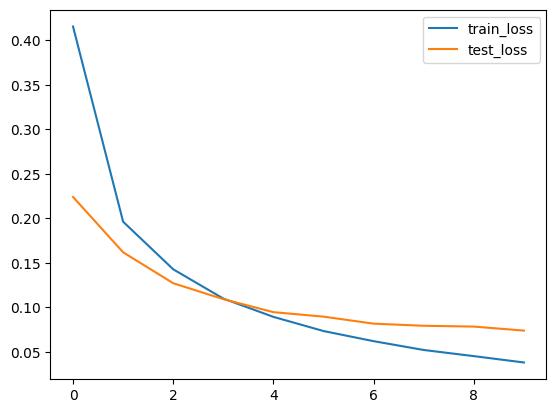

In [12]:
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()

In [13]:
def calculate_acc(data_loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        inputs = inputs.view(-1, 784)
        
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]
        
    acc = n_correct / n_total
    return acc

In [14]:
train_acc = calculate_acc(train_loader)
test_acc = calculate_acc(test_loader)

print(f"train_acc: {train_acc}, test_acc: {test_acc}")

train_acc: 0.9919, test_acc: 0.9763


In [15]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalized=False, 
                          title="confusion_matrix", 
                          cmap=plt.cm.Blues):
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print("confusion_matrix without normalization")
        
    print(cm)
    
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("predicted label")
    plt.show()

In [16]:
def plot_confusion_matrix_sns(cm, 
                          normalized=False, 
                          title="confusion_matrix", 
                          cmap=plt.cm.Blues):
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print("confusion_matrix without normalization")
        
    print(cm)
    
    fmt = '.2f' if normalized else 'd'
    
    sns.heatmap(cm, cmap=cmap, annot=True, fmt=fmt)
    plt.title(title)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("predicted label")
    plt.show()

In [17]:
type(x_test)

torch.Tensor

normalized confusion matrix
[[9.83673469e-01 0.00000000e+00 2.04081633e-03 2.04081633e-03
  3.06122449e-03 0.00000000e+00 3.06122449e-03 2.04081633e-03
  1.02040816e-03 3.06122449e-03]
 [0.00000000e+00 9.91189427e-01 3.52422907e-03 0.00000000e+00
  0.00000000e+00 8.81057269e-04 1.76211454e-03 0.00000000e+00
  2.64317181e-03 0.00000000e+00]
 [3.87596899e-03 9.68992248e-04 9.77713178e-01 3.87596899e-03
  1.93798450e-03 0.00000000e+00 1.93798450e-03 3.87596899e-03
  5.81395349e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.91089109e-03 9.76237624e-01
  9.90099010e-04 1.98019802e-03 0.00000000e+00 2.97029703e-03
  2.97029703e-03 5.94059406e-03]
 [1.01832994e-03 0.00000000e+00 2.03665988e-03 1.01832994e-03
  9.85743381e-01 0.00000000e+00 3.05498982e-03 0.00000000e+00
  0.00000000e+00 7.12830957e-03]
 [2.24215247e-03 0.00000000e+00 0.00000000e+00 1.12107623e-02
  3.36322870e-03 9.64125561e-01 5.60538117e-03 1.12107623e-03
  1.00896861e-02 2.24215247e-03]
 [3.13152401e-03 3.13152401e-0

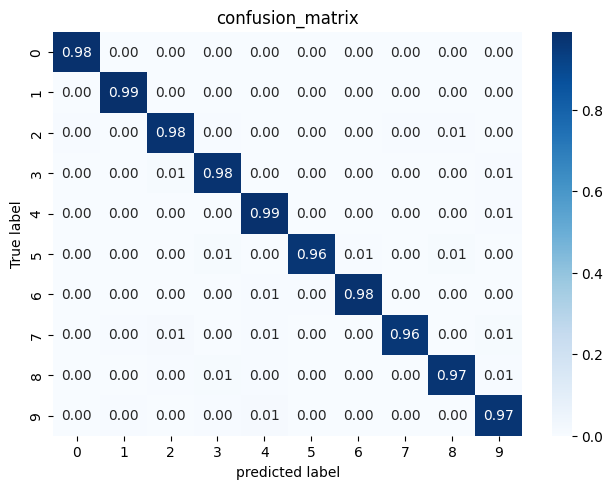

In [18]:
x_test = x_test.numpy()
y_test = y_test.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    inputs = inputs.to(device)
    
    inputs = inputs.view(-1, 784)
    
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs, 1)
    
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    
cm = confusion_matrix(y_test, p_test, labels=np.sort(np.unique(y_test)))
plot_confusion_matrix_sns(cm, normalized=True)

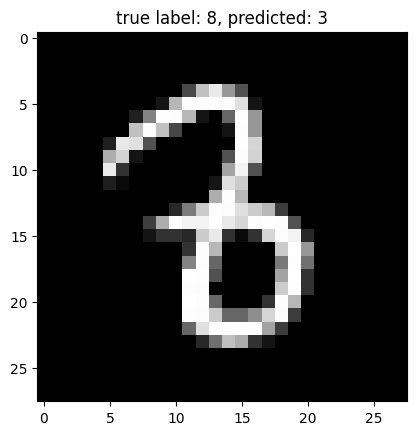

In [19]:
misclassified_index = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_index)
plt.imshow(x_test[i], cmap="gray")
plt.title(f"true label: {y_test[i]}, predicted: {int(p_test[i])}")
plt.show()